In [1]:
import blocksci
import collections
import pandas as pd
import numpy as np
from pathlib import Path


parser_data_directory = Path("/mnt/anal/config.json")
cluster_directory = Path("/mnt/anal/cluster/")
dumplings_directory = Path("/mnt/dumplings/")

chain = blocksci.Blockchain(str(parser_data_directory))

from typing import Tuple

def get_block_height_for_date(date: str) -> int:
    return chain.range(date)[0].height

def get_block_height_range(start: str, end: str) -> Tuple[int, int]:
    return get_block_height_for_date(start), get_block_height_for_date(end)


import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def compute_log_log_graph(ww2, ww1, sw, tag, name):
    cluster_sizes = np.array(list(map(lambda c: c.address_count(), arr)))
    bins = np.logspace(np.log10(cluster_sizes.min()), np.log10(cluster_sizes.max()), num=50)
    hist, bin_edges = np.histogram(cluster_sizes, bins=bins)
    hist = np.where(hist == 0, np.nan, hist)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    plt.figure(figsize=(12, 6))
    plt.plot(bin_centers, hist, marker='o')
    plt.xscale('log')
    plt.yscale('log')    
    plt.title(name)
    plt.xlabel('Cluster Size')
    plt.ylabel('Frequency')
    
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.savefig(f"/mnt/blocksci/{tag}.png")
    plt.show()


Config loaded: 570000 530500 741213 610000


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def compute_cluster_graph(ww1, ww2, sw):
    sizes_ww1 = [cluster.address_count() for cluster in ww1]
    sizes_ww2 = [cluster.address_count() for cluster in ww2]
    sizes_sw = [cluster.address_count() for cluster in sw]
    
    df_ww1 = pd.DataFrame({'size': sizes_ww1})
    df_ww1['coordinator'] = 'Wasabi Wallet 1'
    
    df_ww2 = pd.DataFrame({'size': sizes_ww2})
    df_ww2['coordinator'] = 'Wasabi Wallet 2'
    
    df_sw = pd.DataFrame({'size': sizes_sw})
    df_sw['coordinator'] = 'Samourai Whirlpool'

    df_all = pd.concat([df_ww1, df_ww2, df_sw], ignore_index=True)
    
    # Sort the sizes in descending order for each coordinator
    df_all_sorted = df_all.groupby('coordinator').apply(lambda x: x.sort_values('size', ascending=False)).reset_index(drop=True)
    
    # Add a rank column for plotting
    df_all_sorted['rank'] = df_all_sorted.groupby('coordinator').cumcount() + 1
    
    # Plot the size vs. rank for each coordinator on a log-log scale
    plt.figure(figsize=(10, 6))
    
    for name, group in df_all_sorted.groupby('coordinator'):
        plt.plot(group['rank'], group['size'], label=name)
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Number of clusters')
    plt.ylabel('Cluster Size')
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.title('Cluster Sizes for Coinjoin Coordinators')
    plt.legend()
    plt.savefig("/mnt/blocksci/all_clusters.png")
    plt.show()


# Wasabi2 clusters

In [21]:
start = 0
stop = get_block_height_for_date('2024-10-31')

heuristic = blocksci.heuristics.coinjoin.output_three_hop_threshold \
    and blocksci.heuristics.coinjoin.output_two_hop_threshold \
    and blocksci.heuristics.coinjoin.output_one_hop_threshold \
    and blocksci.heuristics.coinjoin.output_one_hop \
    and blocksci.heuristics.coinjoin.output_one_hop_with_change

%time clusterer = blocksci.cluster.CoinjoinClusterManager.create_clustering(  \
    chain=chain, \
    start=start, \
    stop=stop, \
    output_path="/mnt/anal/clustering/wasabi2_out_threshold_change2/", \
    overwrite=True, \
    coinjoin_type="wasabi2", \
    heuristicFunc=heuristic \
)


Collected 16759406 addresses
Creating disjoint sets of size 16759406
Created disjoint sets of size 16759406
Preparing to serialize cluster data
Serializing cluster data
Serialized
CPU times: user 4min 30s, sys: 51.2 s, total: 5min 21s
Wall time: 1min 21s


In [25]:
ww2_clusterer = blocksci.cluster.CoinjoinClusterManager("/mnt/anal/clustering/wasabi2_out_threshold_change2/", chain)
%time ww2_clusters = [cluster for cluster in ww2_clusterer.clusters() if cluster.address_count() > 1]
%time ww2_clusters_full = [cluster for cluster in ww2_clusterer.clusters()]
print("full", len(ww2_clusters_full))
print("filtered", len(ww2_clusters))

CPU times: user 11.4 s, sys: 70.4 ms, total: 11.4 s
Wall time: 11.5 s
CPU times: user 8.28 s, sys: 1.76 s, total: 10 s
Wall time: 10.1 s
full 16279501
filtered 149160


# Whirlpool clusters
`9ea3e5d217c76e6be6ace7fe4fb3622976103466de81d2b02cd87c54f9e91a2f` should have 21 clustered addresses by the simple one output heuristics
`00ab23721356a159b695060b3975469fa0703e55398e9123ef59d2a5b94b1058` should have 567 addresses clustered

In [5]:
one_random_wp_cj = chain.tx_with_hash("9ea3e5d217c76e6be6ace7fe4fb3622976103466de81d2b02cd87c54f9e91a2f")
one_random_wp_cj = chain.tx_with_hash("00ab23721356a159b695060b3975469fa0703e55398e9123ef59d2a5b94b1058")
one_random_wp_cj = chain.tx_with_hash("021dc91d5d9d74babeed5dbf12a6287cbc4a46317afa357b45c46776940cf902")
address_im_looking_for = one_random_wp_cj.outputs[1].spending_tx.outputs[0].address

start = one_random_wp_cj.block_height
stop = one_random_wp_cj.block_height + 91302

start = 0
stop = get_block_height_for_date('2024-10-31')

heuristic = blocksci.heuristics.coinjoin.output_three_hop_threshold \
    and blocksci.heuristics.coinjoin.output_two_hop_threshold \
    and blocksci.heuristics.coinjoin.output_one_hop_threshold \
    and blocksci.heuristics.coinjoin.output_one_hop \
    and blocksci.heuristics.coinjoin.output_one_hop_with_change


# clusterer = blocksci.cluster.ClusterManager(str(cluster_directory / "fr"), chain)

%time clusterer = blocksci.cluster.CoinjoinClusterManager.create_clustering(  \
    chain=chain, \
    start=start, \
    stop=stop, \
    output_path="/mnt/anal/clustering/whirlpool_out_threshold_change_no_input/", \
    overwrite=True, \
    coinjoin_type="whirlpool", \
    heuristicFunc=heuristic, \
)


Collected 5138453 addresses
Creating disjoint sets of size 5138453
Created disjoint sets of size 5138453
Preparing to serialize cluster data
Serializing cluster data
Serialized
CPU times: user 9min 52s, sys: 18 s, total: 10min 9s
Wall time: 36 s


In [11]:
wp_clusterer = blocksci.cluster.CoinjoinClusterManager("/mnt/anal/clustering/whirlpool_out_threshold_change_no_input/", chain)
%time wp_clusters = [cluster for cluster in wp_clusterer.clusters() if cluster.address_count() > 1]
%time wp_clusters_full = [cluster for cluster in wp_clusterer.clusters()]
print("full", len(wp_clusters_full))
print("filtered", len(wp_clusters))


CPU times: user 3.41 s, sys: 50.1 ms, total: 3.46 s
Wall time: 3.49 s
CPU times: user 3.95 s, sys: 883 ms, total: 4.84 s
Wall time: 4.88 s
full 4809477
filtered 30938


# Wasabi1 clustering


In [23]:
# import random

# one_random_wp_cj = chain.tx_with_hash("9ea3e5d217c76e6be6ace7fe4fb3622976103466de81d2b02cd87c54f9e91a2f")
# one_random_wp_cj = chain.tx_with_hash("00ab23721356a159b695060b3975469fa0703e55398e9123ef59d2a5b94b1058")
#address_im_looking_for = one_random_wp_cj.outputs[1].spending_tx.outputs[0].address
# print(address_im_looking_for) 10213510

start = 0
stop = get_block_height_for_date('2024-10-31')


heuristic = blocksci.heuristics.coinjoin.output_three_hop_threshold \
    and blocksci.heuristics.coinjoin.output_two_hop_threshold \
    and blocksci.heuristics.coinjoin.output_one_hop_threshold \
    and blocksci.heuristics.coinjoin.output_one_hop \
    and blocksci.heuristics.coinjoin.output_one_hop_with_change



%time clusterer = blocksci.cluster.CoinjoinClusterManager.create_clustering(  \
    chain=chain, \
    start=start, \
    stop=stop, \
    output_path="/mnt/anal/clustering/wasabi1_out_threshold_change2/", \
    overwrite=True, \
    coinjoin_type="wasabi1", \
    heuristicFunc=heuristic, \
)


Collected 10290298 addresses
Creating disjoint sets of size 10290298
Created disjoint sets of size 10290298
Preparing to serialize cluster data
Serializing cluster data
Serialized
CPU times: user 5min 22s, sys: 17.1 s, total: 5min 39s
Wall time: 1min


In [24]:
ww1_clusterer = blocksci.cluster.CoinjoinClusterManager("/mnt/anal/clustering/wasabi1_out_threshold_change2/", chain)
%time ww1_clusters = [cluster for cluster in ww1_clusterer.clusters() if cluster.address_count() > 1]
%time ww1_clusters_full = [cluster for cluster in ww1_clusterer.clusters()]
print("full", len(ww1_clusters_full))
print("filtered", len(ww1_clusters))

#compute_log_log_graph(ww1_clusters, "ww1_clusters_1", "WW1 Cluster sizes")

CPU times: user 7.03 s, sys: 116 ms, total: 7.15 s
Wall time: 7.18 s
CPU times: user 4.26 s, sys: 604 ms, total: 4.87 s
Wall time: 4.9 s
full 9901812
filtered 96373


## No clusters
not working yet :c

In [ ]:
start = 0
stop = get_block_height_for_date('2024-10-31')

heu = blocksci.heuristics.coinjoin.input_one_hop
heu = heu and blocksci.heuristics.coinjoin.output_three_hop_threshold
heu = heu and blocksci.heuristics.coinjoin.output_two_hop_threshold 
heu = heu and blocksci.heuristics.coinjoin.output_one_hop
heu = heu and blocksci.heuristics.coinjoin.output_one_hop_with_change


no_clusterer = blocksci.cluster.CoinjoinClusterManager.create_clustering( \
    chain=chain, \
    start=start, \
    stop=stop, \
    output_path="/mnt/anal/clustering/no_cj_out_threshold_change/", \
    overwrite=True, \
    coinjoin_type=blocksci.CoinJoinType.NoCJ, \
    heuristicFunc=heu, \
)

In [ ]:
no_cj_clusterer = blocksci.cluster.CoinjoinClusterManager("/mnt/anal/clustering/no_cj_out_threshold_change/", chain)
%time no_cj_clusters = [cluster for cluster in no_cj_clusterer.clusters() if cluster.address_count() > 1]

## Results

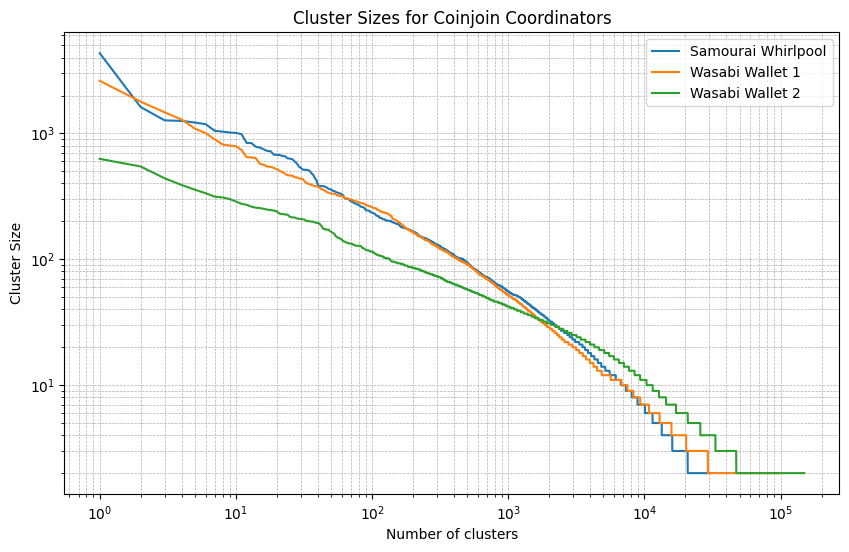

In [29]:
compute_cluster_graph(ww1_clusters, ww2_clusters, wp_clusters)

# Other cluster statistics

In [3]:
ww1_clusterer = blocksci.cluster.CoinjoinClusterManager("/mnt/anal/clustering/wasabi1_out_threshold_change2/", chain)
wp_clusterer = blocksci.cluster.CoinjoinClusterManager("/mnt/anal/clustering/whirlpool_out_threshold_change_no_input/", chain)
ww2_clusterer = blocksci.cluster.CoinjoinClusterManager("/mnt/anal/clustering/wasabi2_out_threshold_change2/", chain)

In [4]:
%time ww2_clusters = [cluster for cluster in ww2_clusterer.clusters() if cluster.address_count() > 1]
%time ww1_clusters = [cluster for cluster in ww1_clusterer.clusters() if cluster.address_count() > 1]
%time wp_clusters = [cluster for cluster in wp_clusterer.clusters() if cluster.address_count() > 1]


CPU times: user 11.6 s, sys: 3.6 s, total: 15.2 s
Wall time: 15.4 s
CPU times: user 6.96 s, sys: 1.94 s, total: 8.9 s
Wall time: 8.96 s
CPU times: user 3.29 s, sys: 222 ms, total: 3.51 s
Wall time: 3.53 s


In [10]:
from tabulate import tabulate

print(tabulate(
    [
        [
            "Wasabi Wallet 1", 
            10290298,
            len(ww1_clusters), 
            max(ww1_clusters, key=lambda c: c.address_count()).address_count()
        ],
        [
            "Wasabi Wallet 2", 
            16759406,
            len(ww2_clusters), 
            max(ww2_clusters, key=lambda c: c.address_count()).address_count()
        ],
        [
            "Samourai Whirlpool", 
            5138453,
            len(wp_clusters), 
            max(wp_clusters, key=lambda c: c.address_count()).address_count()
        ],
        
    ],
    headers=['Pool', "Total addresses collected", "Number of clusters", "Biggest cluster size"], 
    tablefmt='orgtbl'
    )
)


| Pool               |   Total addresses collected |   Number of clusters |   Biggest cluster size |
|--------------------+-----------------------------+----------------------+------------------------|
| Wasabi Wallet 1    |                    10290298 |                96373 |                   2620 |
| Wasabi Wallet 2    |                    16759406 |               149160 |                    628 |
| Samourai Whirlpool |                     5138453 |                30938 |                   4344 |


In [77]:
def plot_biggest_clusters(ww1, ww2, sw, coordinator):

    def process(biggest_clusters):
        a: blocksci.Address
        
        all_cluster_transactions = set()

        for c in biggest_clusters:
            for tx in c.txes():
                all_cluster_transactions.add(tx)
        
        
        df_cluster = pd.DataFrame([(tx.block_time, 1) for tx in all_cluster_transactions], columns=["time", "count"])
        df_cluster["week_start"] = df_cluster["time"].dt.to_period("W").apply(lambda r: r.start_time)
        weekly_cluster = df_cluster.groupby("week_start")["count"].sum().reset_index()
        return weekly_cluster

    df_ww1 = process(ww1)
    df_ww2 = process(ww2)
    df_sw = process(sw)
    df_coordinator = process(coordinator)
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(df_ww1['week_start'], df_ww1["count"], label="WW1", marker='o')
    plt.plot(df_ww2['week_start'], df_ww2["count"], label="WW2", marker='o')
    plt.plot(df_sw['week_start'], df_sw["count"], label="Whirlpool", marker='o')
    plt.plot(df_coordinator['week_start'], df_coordinator["count"], label="WW1 static coordinator addresses", ls='--')
    plt.grid(ls='--')

    plt.xlabel('Time')
    plt.ylabel('Transaction count')
    plt.title('Activity of the addresses of the largest clusters')
    plt.legend()
    plt.savefig('/mnt/blocksci/activity.png')
    plt.show()

In [40]:
ww1_largest_clusters = list(sorted(ww1_clusters, key=lambda c: c.address_count()))[-2:]
ww2_largest_clusters = list(sorted(ww2_clusters, key=lambda c: c.address_count()))[-2:]
sw_largest_clusters = list(sorted(wp_clusters, key=lambda c: c.address_count()))[-2:]

plot_biggest_clusters(ww1_largest_clusters, ww2_largest_clusters, sw_largest_clusters)

TypeError: plot_biggest_clusters() missing 1 required positional argument: 'coordinator'

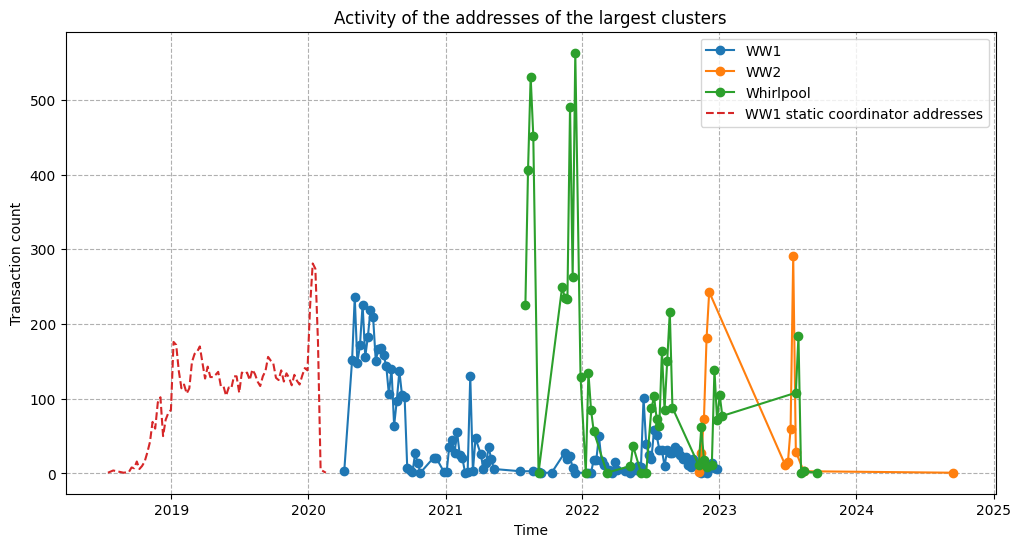

In [45]:
coordinator_cluster = [ww1_clusterer.cluster_with_address(chain.address_from_string("bc1qs604c7jv6amk4cxqlnvuxv26hv3e48cds4m0ew")), ww1_clusterer.cluster_with_address(chain.address_from_string("bc1qa24tsgchvuxsaccp8vrnkfd85hrcpafg20kmjw"))]

plot_biggest_clusters(ww1_largest_clusters, ww2_largest_clusters, sw_largest_clusters, coordinator_cluster)

In [53]:
coordinator_cluster = ww1_clusterer.cluster_with_address(chain.address_from_string("bc1qs604c7jv6amk4cxqlnvuxv26hv3e48cds4m0ew"))

for address in coordinator_cluster.addresses.to_list():
    print(address)
    print(len(list(address.txes)))

ScriptHashAddress(3CuEa41MFzuKF7Vs48L9Yh89nD3CXqw51M, wrapped_address=bc1qpwy023faymtq5kallwrey0fv2zhrmucavww287)
2
bc1qs604c7jv6amk4cxqlnvuxv26hv3e48cds4m0ew
5373
bc1q7efa80squh3w6g7hdt292kky4j5j64ah262fzg
2
bc1q7dc06php6fyxtk7yh9dd0a2f5cau0zly2wtc6z
2


In [18]:
ww1_biggest_cluster = max(ww1_clusters, key=lambda c: c.address_count())
ww2_biggest_cluster = max(ww2_clusters, key=lambda c: c.address_count())
wp_biggest_cluster = max(wp_clusters, key=lambda c: c.address_count())

print(next(iter(ww1_biggest_cluster.addresses.to_list())))
print(next(iter(ww2_biggest_cluster.addresses.to_list())))
print(next(iter(wp_biggest_cluster.addresses.to_list())))

bc1qg5jtuu7rms3cgkwuhqwvdqm2vxkfcz5ya9jplz
bc1qt4u53hwjqxfvsndjjxzxxaghj20a7329e8sr8m
ScriptHashAddress(3J8pKBNnp6rxy6UaXxJiPixbDrtUaNmF2C, wrapped_address=bc1q2k7cvvetvd6zl8reg0y2zjyzld9mgzgsa5kdv5)


In [37]:
address: blocksci.Address

for c in (ww1_largest_clusters[0], ww2_largest_clusters[0], sw_largest_clusters[0]):
    for address in sorted(c.addresses.to_list(), key=lambda a: len(a.txes.to_list()), reverse=True):
        print(address)
        break

bc1qy9l3vunu0grqd07j6ls2yp39dlz3cmm4rnhyyw
bc1qh2zad5rrrhyjqlygj6wstq32z55e0ue8wvkrej
ScriptHashAddress(3J8pKBNnp6rxy6UaXxJiPixbDrtUaNmF2C, wrapped_address=bc1q2k7cvvetvd6zl8reg0y2zjyzld9mgzgsa5kdv5)


# Tagged clusters

We use [graphsense-tagpacks](https://github.com/graphsense/graphsense-tagpacks/blob/master/actors/graphsense.actorpack.yaml) to tag the clusters we form with tags.

In [116]:
import yaml
import os

TAGPACK_DIRECTORY = Path('/mnt/anal/graphsense-tagpacks')

with open(TAGPACK_DIRECTORY / 'actors' / 'graphsense.actorpack.yaml') as f:
    actors = yaml.safe_load(f)['actors']

packs = {}

def parse_address_currency_structure(data, packs):
    label = data.get('label')
    if label not in ('exchange', 'Asset listed under US Treasury OFAC Sanctions List', 'binance.com', 'Internet Archive'):
        return 
        
    tags = data['tags']
    currency = data.get('currency')
    for dct in tags:
        if dct.get('currency') == 'BTC' or currency == 'BTC':
            address = chain.address_from_string(dct['address'])
            if address is not None:
                packs[address] = label

def parse_label_actor_structure(data, packs):
    label = data['category']
    if label not in ('exchange', 'Asset listed under US Treasury OFAC Sanctions List', 'binance.com', 'Internet Archive'):
        return 
    currency = data['currency']
    if currency != 'BTC':
        return 
        
    for dct in data['tags']:
        address = chain.address_from_string(dct['address'])
        packs[address] = label



for root, _, files in os.walk(TAGPACK_DIRECTORY / 'packs'):
    for file in files:
        if file.endswith((".yaml", ".yml")):
            file_path = os.path.join(root, file)
            with open(file_path, 'r') as yaml_file:
                try:
                    data = yaml.safe_load(yaml_file)
                    label = data.get('label')
                    if label is None:
                        parse_label_actor_structure(data, packs)
                    else:
                        parse_address_currency_structure(data, packs)
                        
                    
                except yaml.YAMLError as e:
                    print(f"Error parsing {file_path}: {e}")
                except KeyError as e:
                    print(f"Error parsing {file_path}: {e}")
                except RuntimeError as e:
                    print(f"Error parsing {file_path}: {e}")


print(len(packs))

Error parsing /mnt/anal/graphsense-tagpacks/packs/defi-protocols-csh.yaml: 'category'
Error parsing /mnt/anal/graphsense-tagpacks/packs/etherscamdb_tagpack.yaml: 'category'
Error parsing /mnt/anal/graphsense-tagpacks/packs/etherscan-label-word-cloud.yaml: 'category'
Error parsing /mnt/anal/graphsense-tagpacks/packs/exchange-wallets-binance.yaml: 'currency'
Error parsing /mnt/anal/graphsense-tagpacks/packs/exchange-wallets-bitfinexcom.yaml: 'currency'
Error parsing /mnt/anal/graphsense-tagpacks/packs/exchange-wallets-huobi.yaml: 'currency'
Error parsing /mnt/anal/graphsense-tagpacks/packs/hacks.yaml: 'category'
Error parsing /mnt/anal/graphsense-tagpacks/packs/interpol-real_services.yaml: 'category'
Error parsing /mnt/anal/graphsense-tagpacks/packs/ponzi_scheme.yaml: 'category'
Error parsing /mnt/anal/graphsense-tagpacks/packs/ransomware.yaml: 'category'
Error parsing /mnt/anal/graphsense-tagpacks/packs/ransomwhere.yaml: 'category'
Error parsing /mnt/anal/graphsense-tagpacks/packs/riche

In [101]:
def plot_tagged_clusters(ww1, ww2, sw):

    def process(biggest_clusters):
        a: blocksci.Address
        
        all_cluster_transactions = set()

        for c in biggest_clusters:
            for tx in c.txes():
                all_cluster_transactions.add(tx)
        
        
        df_cluster = pd.DataFrame([(tx.block_time, 1) for tx in all_cluster_transactions], columns=["time", "count"])
        df_cluster["week_start"] = df_cluster["time"].dt.to_period("W").apply(lambda r: r.start_time)
        weekly_cluster = df_cluster.groupby("week_start")["count"].sum().reset_index()
        return weekly_cluster

    df_ww1 = process(ww1)
    df_ww2 = process(ww2)
    df_sw = process(sw)
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(df_ww1['week_start'], df_ww1["count"], label="WW1", linewidth=0.7)
    plt.plot(df_ww2['week_start'], df_ww2["count"], label="WW2", linewidth=0.7)
    plt.plot(df_sw['week_start'], df_sw["count"], label="Whirlpool", linewidth=0.7)
    plt.grid(ls='--')

    plt.xlabel('Time')
    plt.ylabel('Transaction count')
    plt.title('Activity of the addresses of the clusters labeled as "Alt-right entity"')
    plt.legend()
    # plt.savefig('/mnt/blocksci/activity.png')
    plt.show()

---- label: ww1 ----
---- label: sw ----
---- label: ww2 ----


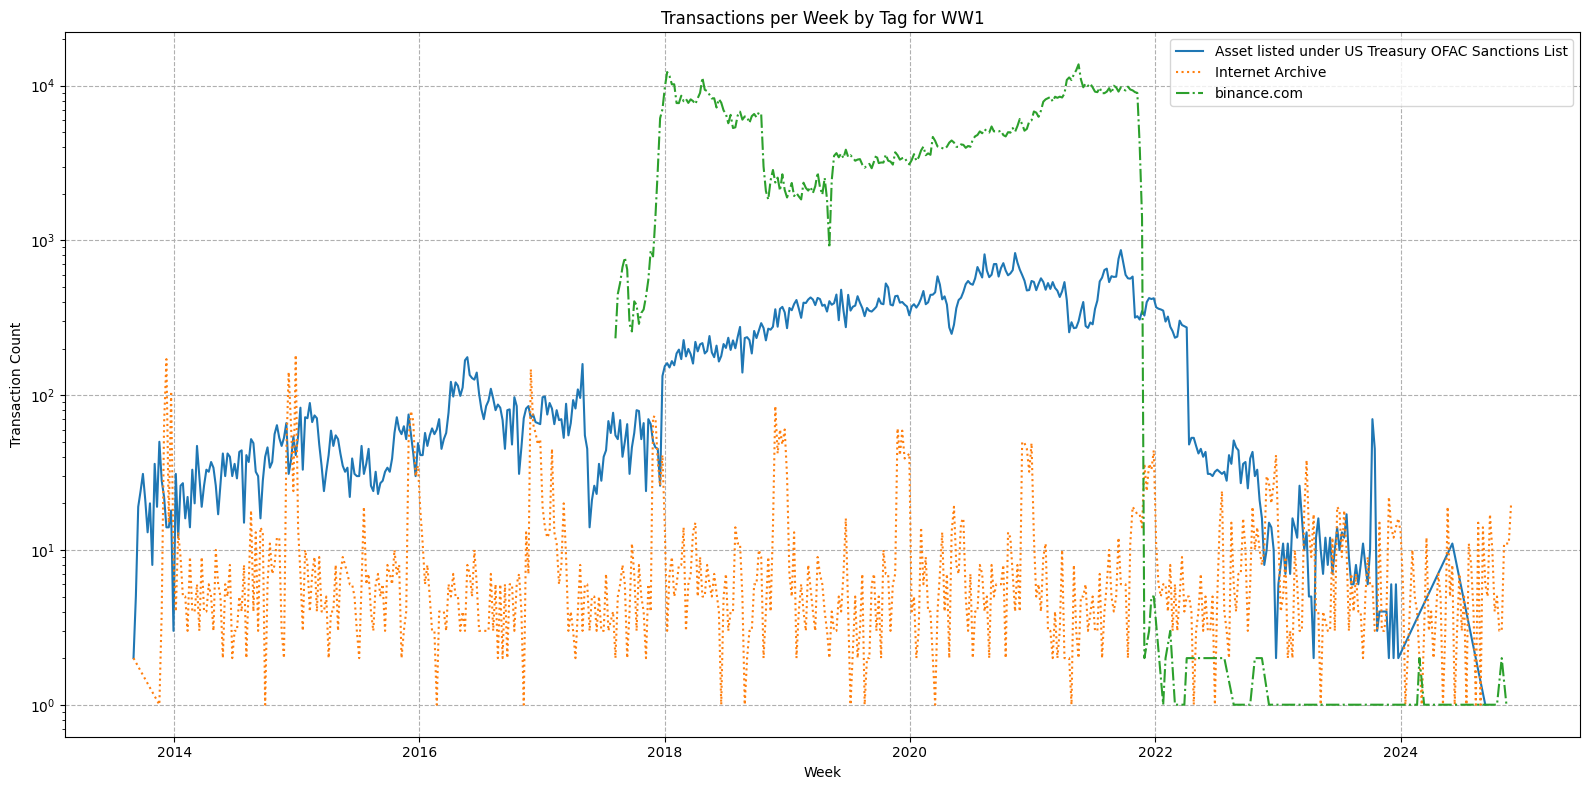

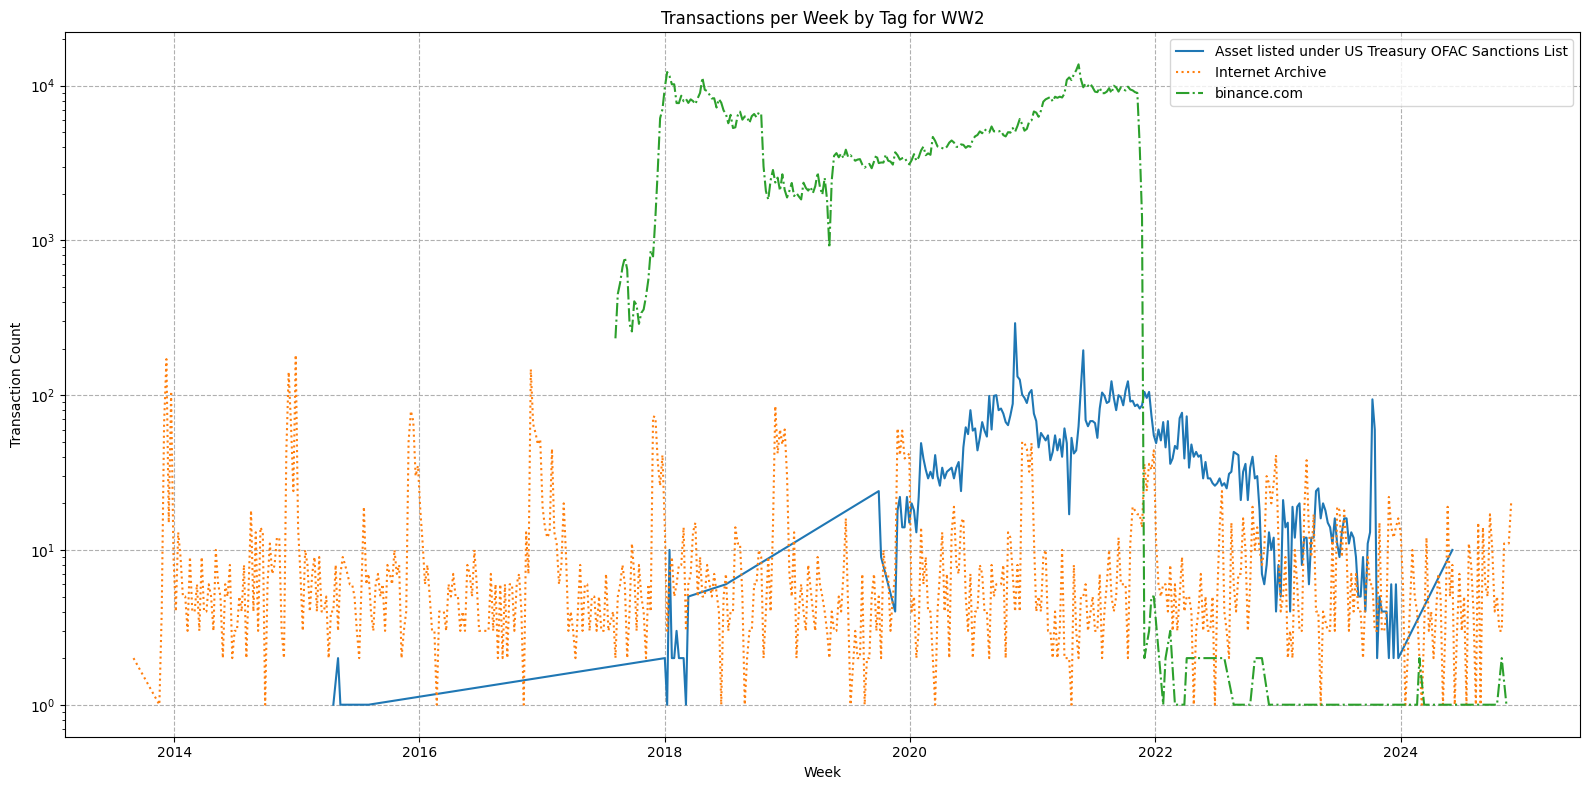

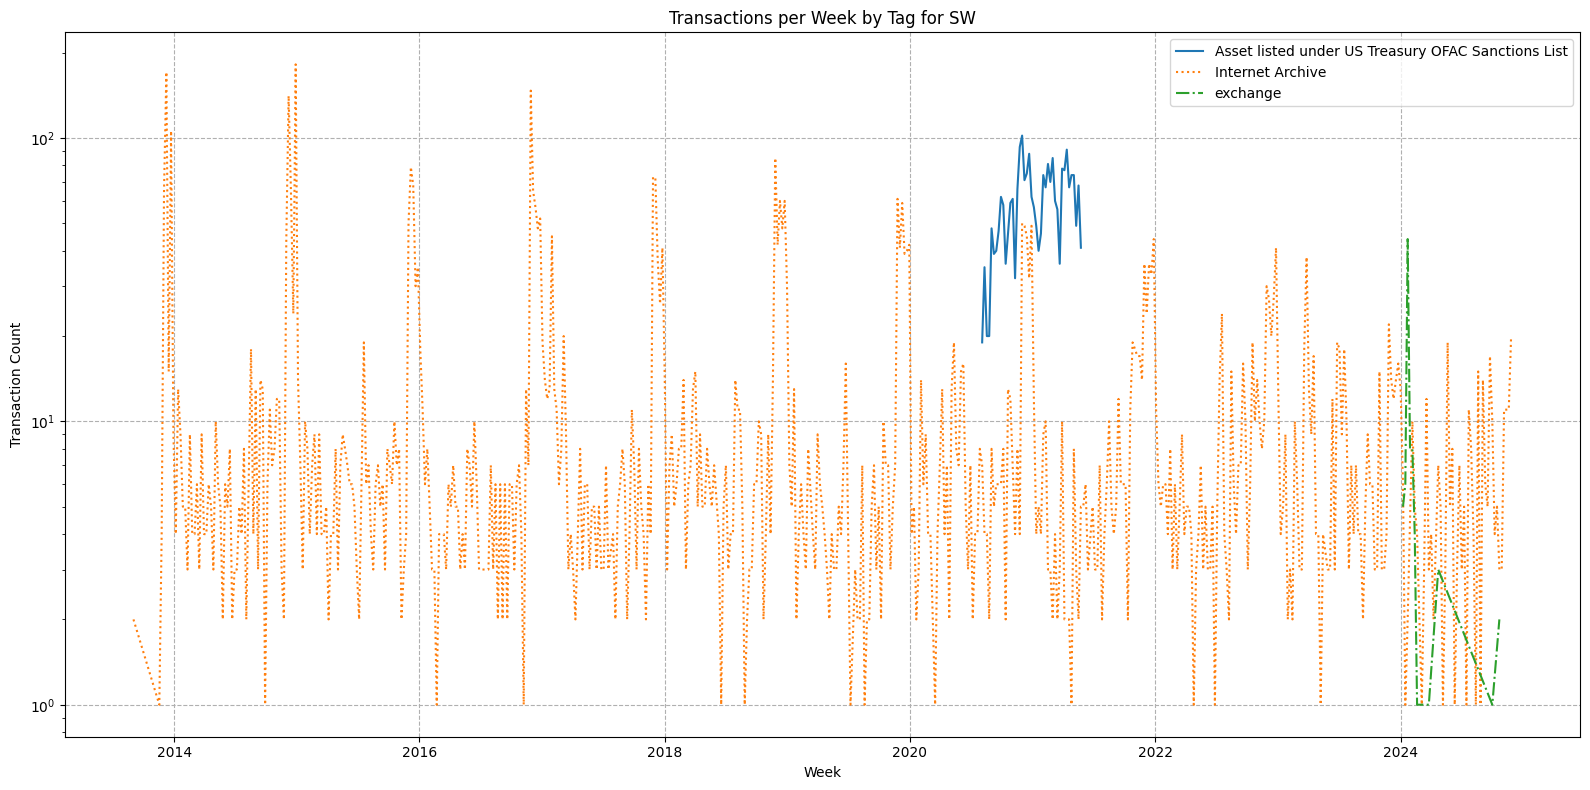

In [118]:
def tagged_clusters_evaluation(clusterer, label):
    print(f"---- label: {label} ----")
    tagged_clusters = clusterer.tagged_clusters(packs)
    
    a: blocksci.cluster.TaggedAddress
    notable_labels = {}
    
    for tc in tagged_clusters:
        ta = tc.tagged_addresses
        for a in ta:
            if a.tag not in notable_labels:
                notable_labels[a.tag] = []
            notable_labels[a.tag].append(clusterer.cluster_with_address(a.address))

    
    return notable_labels

def plot_label_cluster_graph_interactions(data, graph_label):
    rows = []

    for tag, clusters in data.items():
        for cluster in clusters:
            for tx in cluster.txes():
                rows.append({
                    "tag": tag,
                    "time": tx.block_time,
            })
    
    df = pd.DataFrame(rows)
    df['week'] = df['time'].dt.to_period('W').dt.start_time
    grouped = df.groupby(['tag', 'week']).size().reset_index(name='tx_count')
    
    # Plot the data
    plt.figure(figsize=(16, 8))
    for tag, ls in zip(grouped['tag'].unique(), ['-', ':', '-.']):
        tag_data = grouped[grouped['tag'] == tag]
        plt.plot(tag_data['week'], tag_data['tx_count'], label=tag, ls=ls)

    plt.xlabel("Week")
    plt.ylabel("Transaction Count")
    plt.yscale('log')

    plt.title(f"Transactions per Week by Tag for {graph_label}")
    plt.legend()
    plt.tight_layout()
    plt.grid(ls='--')
    plt.show()
    



ww1_tagged_clusters = tagged_clusters_evaluation(ww1_clusterer, "ww1")
sw_tagged_clusters = tagged_clusters_evaluation(wp_clusterer, "sw")
ww2_tagged_clusters = tagged_clusters_evaluation(ww2_clusterer, "ww2")

plot_label_cluster_graph_interactions(ww1_tagged_clusters, "WW1")
plot_label_cluster_graph_interactions(ww2_tagged_clusters, "WW2")
plot_label_cluster_graph_interactions(sw_tagged_clusters, "SW")



In [99]:
print(set(packs.values()))


{'crypto.com reserves wallets', 'checksig reserve wallets', 'deribit reserves', 'binance.com', 'Internet Archive', 'swisborg reserve wallets', 'lockbit_tattoo', 'mixing_service', 'Protonmail', 'Coinjoin Bounty', 'miner', 'Suidlanders', 'kucoin reserve wallets', 'Africrypt', 'Sextortion Spam', 'Lazarus group', 'Asset listed under US Treasury OFAC Sanctions List', 'sinbad.io', 'Plus Token Scam', 'Twitter Hack Scam', 'binance hack', 'Alt-Right Entity', 'Al-Qaeda Campaign', 'Bybit reserve wallets', 'bitmex reserve wallet', 'Wasabi Fee', 'Samourai Wallet', 'Electrum phishing', 'okx reserves wallets', 'exchange'}
